# CSC421 Assignment 3 - Part I  Simulation and Probabilities (5 points) #
### Author: George Tzanetakis 

This notebook is based on the supporting material for topics covered in **Chapter 13 Quantifying Uncertainty** from the book *Artificial Intelligence: A Modern Approach.* This part does NOT rely on the provided code so you can complete it just using basic Python. 

```
Misunderstanding of probability may be the greatest of all impediments
to scientific literacy.

Gould, Stephen Jay
```

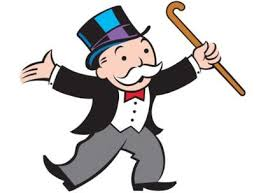


# Introduction - Simulation for approximate estimation of probabilities 

In this assignment your task is to incrementally create a simulation for the board game Monopoly
https://en.wikipedia.org/wiki/Monopoly_(game). Very interesting origin story for the game: 
https://www.saturdayeveningpost.com/2017/09/really-invented-monopoly/


**NOTE THAT THE GRADING IN THIS ASSIGNMENT IS DIFFERENT FOR GRADUATE STUDENTS AND THEY HAVE TO DO EXTRA WORK FOR FULL MARKS**

Consider simulating a game of Monopoly. Your goal is to experimentally determine the cummulative probability of landing on each square following the rules of the game after 100 moves. By cummulative I mean the total
number of times you land on a square during a play. So for example if you land on the Free Parking square 5 times during the 100 moves in a particular run of the simulation then the probability of landing on that square is 5/100.

To get accurate probabilities you will have to run 1000 simulated games. You can assume that you are only a considering a single player and you ignore buying/selling property. You will need to simulate chance cards, rolling the dice including doubles, and going to jail. The following article has some
information you can use in your simulation http://www.businessinsider.com/math-monopoly-statistics-2013-6.

You can use the random variables and probability notebook code we covered in class or directly implement the random sampling to simulate playing the Monopoly game 1000 times and show on a table what is the probability of landing in each railway station, the GO square, Mediterenean Avenue and Boardwalk. The questions below break this problem into incremental steps. 


# Question 1A (Minimum) CSC421 -  (1 point, CSC581C - 0 points) 

Write code to generate random numbers corresponding to rolling a pair of dice and summing the output taking into account the doubling rule (when you roll doubles you get to roll again). Include all the code with comments describing what you are doing. 

In [143]:
import numpy as np
from random import randint
from tabulate import tabulate
from ipythonblocks import BlockGrid

In [144]:
def roll():
    moves = []
    # Allowed at most 3 rolls
    for i in range(3):
        x = randint(1, 6)
        y = randint(1, 6)
        moves.append(x + y)
        # Not a double turn over
        if x != y:
            break
        # 3 doubles go to jail (speeding)
        if i == 2:
            moves[2] = -1
            break            
    return moves   

# simplification of needing to roll doubles to get out of jail
def roll_double():
    return [randint(1, 6) * 2]

# Question 1B (Minimum) (CSC421 - 1 point, CSC581C - 0 point) 

Write code for selecting a chance card at random based on the information provided in the article about the math of Monopoly. The chance cards that are not about movement will be ignored in this assignment but you should still 
simulate them. 

In [145]:
def chance(location):
    i = randint(1, 16)
    # advance to go collect $200
    if i == 1:
        return  0
    # go to jail
    if i == 2:
        return 10
    # nearest utiliy
    if i == 3:
        if location == 7 or location == 36:
            return 12
        return 28
    # nearest railroad
    if i == 4:
        if location == 7:
            return 15
        if location == 22:
            return 25
        return 5
    # take a trip to Reading Railroad
    if i == 5:
        return 5
    # take a walk on the Boardwalk
    if i == 6:
        return 39
    # advance to St. Charles Place
    if i == 7:
         return 11
    # advance to Illinois Ave
    if i == 8:
        return 24
    # back 3 spaces
    if i == 9:
        return -3
    # remainder of cards aren't movement
    return -1
    
def community_chest():
    i = randint(1, 16)
    # advance to go collect $200
    if i == 1:
        return  0
    # go to jail
    if i == 2:
        return 10
    # remainder of cards aren't movement
    return -1


# Question 1C (Expected) 1 point 

Write code to simulate movement around the board for one player with rolling pair of dice as well as the doubling rule. For this question you don't need to simulate go to jail and chance cards (you will do that in the next question) 


In [146]:
# assumption: when rolling 3 doubles in a row the last roll is ignored rahter than going to jail 
def simple_movement():
    location = 0
    locations = np.zeros(40)
    # turns
    for i in range(100):
        moves = roll()
        for m in moves:
            if m != -1:
                location = (location + m) % 40
                locations[location] += 1
    print(locations)
    
simple_movement()
        

[0. 3. 4. 6. 3. 2. 3. 2. 4. 1. 4. 5. 3. 2. 4. 4. 1. 5. 4. 3. 2. 3. 4. 3.
 2. 4. 6. 0. 3. 4. 3. 0. 4. 5. 4. 2. 5. 3. 3. 3.]


# QUESTION 1D (EXPECTED) 1 point

Add the code for go to jail and chance cards. Record how many times you land on
each square after playing a game consisting of 100 moves. Run the simulation 1000 times 
and average the landing results. Show in a table the following probabilities: each railway station, the GO square, Mediterenean Avenue and Boardwalk.



In [147]:
def simulate(tries=1000, turns=100):
    board = np.zeros(40)
    jail_time = 0
    for t in range(tries):
        location = 0
        jailed = False
        for turn in range(turns):
            moves = None
            if jailed:
                moves = roll_double()
                jail_time += 1
                jailed = False
            else:
                moves = roll()
            for m in moves:
                # speeding
                if m == -1:
                    location = 10
                    board[location] += 1
                    jailed = True
                else:
                    location = (location + m) % 40
                    board[location] += 1
                    
                    # go to jail
                    if location == 30:
                        location = 10
                        board[location] += 1
                        jailed = True
                    
                    # chance
                    if location in [7, 22, 36]:
                        c = chance(location)
                        if c == -3:
                            location = location - 3
                            board[location] += 1
                        if c >= 0:
                            location = c
                            board[location] += 1
                            if c == 10:
                                jailed = True
                    
                    # community chest
                    if location in [2, 17, 33]:
                        c = community_chest()
                        if c >= 0:
                            location = c
                            board[location] += 1
                            if c == 10:
                                jailed = True
    
    return ([x / tries for x in board], jail_time / 1000)

results = simulate()[0]
prob = [x / sum(results) for x in results]

print(tabulate([
    ['Reading Railroad', prob[5]], 
    ['Pennsylvania Line', prob[15]], 
    ['B&O Railroad', prob[25]],
    ['Short Line', prob[35]],
    ['GO', prob[0]],
    ['Mediterenean Ave', prob[1]],
    ['Boardwalk', prob[39]]],
    headers=['Square', 'Probability']
))


Square               Probability
-----------------  -------------
Reading Railroad       0.0267728
Pennsylvania Line      0.0229437
B&O Railroad           0.0256766
Short Line             0.021542
GO                     0.0285582
Mediterenean Ave       0.0197253
Boardwalk              0.0241026


# QUESTION 1E (ADVANCED) 1 point 

Write code that visualizes the board and associated probabilities in color using some kind of colormap. You can use any Python library for handling this. Some possibilities with different tradeoffs include ipythonblocks, bokeh, and PyGame. 

In [150]:
def get_color(p):
    if p < 0.019:
        return (255, 255, 255)
    if p < 0.021:
        return (237, 232, 232)
    if p < 0.023:
        return (223, 205, 205)
    if p < 0.025:
        return (214, 173, 173)
    if p < 0.027:
        return (209, 136, 136)
    if p < 0.029:
        return (209, 95, 95)
    if p < 0.031:
        return (214, 49, 49)
    if p < 0.033:
        return (197, 25, 25)
    if p < 0.034:
        return (170, 10, 10)
    return (139, 0, 0)

black = (0, 0, 0)
white = (255, 255, 255)
brown = (151, 87, 55)
light_blue = (170, 225, 251)
pink = (221, 58, 151)
orange = (245, 148, 28)
red = (236, 27, 32)
yellow = (255, 239, 0)
green = (33, 176, 90)
blue = (0, 113, 186)

board = BlockGrid(11, 11, fill=(220, 220, 220))
board[1:-1, 1:-1] = (206, 230, 208)

board[10, 9] = brown
board[10, 7] = brown
board[10, 4] = light_blue
board[10, 2] = light_blue
board[10, 1] = light_blue
board[9, 0] = pink
board[7, 0] = pink
board[6, 0] = pink
board[4, 0] = orange
board[2, 0] = orange
board[1, 0] = orange
board[0, 1] = red
board[0, 3] = red
board[0, 4] = red
board[0, 6] = yellow
board[0, 7] = yellow
board[0, 9] = yellow
board[1, 10] = green
board[2, 10] = green
board[4, 10] = green
board[7, 10] = blue
board[9, 10] = blue
board[10, 5] = black
board[0, 5] = black
board[5, 10] = black
board[5, 0] = black
board[0, 8] = white
board[9, 0] = white

print('Monopoly Board with Colored Properties')
board.show()

results = simulate()[0]
prob = [x / sum(results) for x in results]

grid = BlockGrid(11, 11, fill=(206, 230, 208))

# bottom: GO - Connecticut Ave
for i, j in zip(range(10, 0, -1), range(0, 10)):
    grid[10, i] = get_color(prob[j])
# left: Jail - New York Ave
for i, j in zip(range(10, 0 , -1), range(10, 20)):
    grid[i, 0] = get_color(prob[j])
# top: Free Parking - Marvin Gardens
for i, j in zip(range(0, 10), range(20, 30)):
    grid[0, i] = get_color(prob[j])
# right: Go to Jail - Boardwalk
for i, j in zip(range(0, 10), range(30, 40)):
    grid[i, 10] = get_color(prob[j])

print('Probability of landing on a square')
grid.show()


Monopoly Board with Colored Properties


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,


Probability of landing on a square


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,


# QUESTION 1F (ADVANCED) (CSC421 - 0 points, CSC581C - 2 points)

Implement code for handling the money aspect of monopoly and extend your simulation to handle multi-player playing by creating a very simple buying/selling AI for example randomly selecting one or the other action. 
You shoud be able to step through a fully simulated Game of Monopoly and see how everything is working. You can ignore building and assume that when a player lands in a property square they can purchase it at a predefined price and after they purchase it anyone who lands on that square pays a fixed fee. Also no need to simulate getting properties of the same color. 

Of course if you feel ambitious and want to do a full simulation of the actual game that's perfectly fine and 
you will not be penalized for the extra features. 



In [50]:
# YOUR CODE GOES HERE 